# Poprawa współczynników filtru 
---
<p align="center">
    <img src="./doc/img/FIR.png", width = "500px">
</p>

## Sekcja konfiguracyjna 

In [1]:
# Parametry filtru
filter = {
    'N_fft':   512,     # FFT N próbek -> 2^m
    'm_order': 51,      # Długość filtru
    'fs':      48e3,    # Częstotliwość próbkowania
    'f_pass':  9.6e3,   # Częstotliwość graniczna pasma zaporowego
    'tr_band': 0.2e3,   # Szerokość pasma przejściowego
    'd1_db':   2,       # df1 [db] maksymalne pulsacje w paśmie przepustowym
    'd2_db':   -50,     # df2 [db] minimalna wartość tłumienia w paśmie zaporowym
}

## Wyznaczanie parametrów filtru - metoda okna

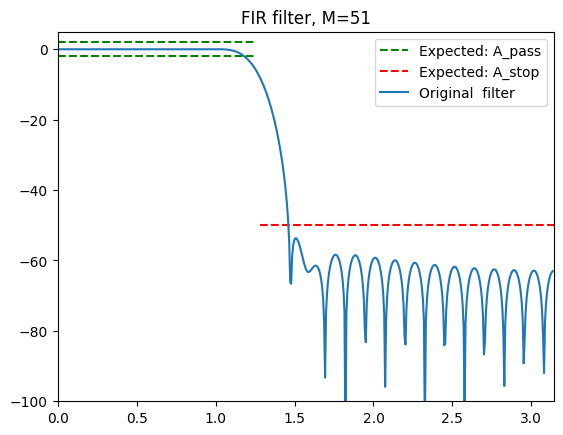

Initial value cost function: 38.870656741820845 


In [2]:
from filter import filter_utils
from scipy import signal
import numpy as np

# Normalizacja filtru f->2pi
filter_n = filter_utils.normalize_filter (filter)

# Współczynniki filtru metoda okienkowa
coef     = signal.firwin(filter['m_order'], filter['f_pass'], fs=filter['fs'], window='hamming')
f, f_res = signal.freqz(coef, worN=filter['N_fft'])

# Wyświetlenie parametrów filtru
filter_utils.display_LP_filter(f[np.newaxis,:], f_res[np.newaxis,:], filter_n)

# Domyślna wartość funkcji kosztu
cost_val = filter_utils.cost_LP_filter(abs(f_res), filter_utils.db_to_linear(filter_n['d1_db'])-1, filter_utils.db_to_linear(filter_n['d2_db']), filter_n['f_pass'], filter_n['tr_band'])
print("Initial value cost function: {} ".format(cost_val))

## Poprawa współczynników filtru - metoda bazująca na sąsiedztwie

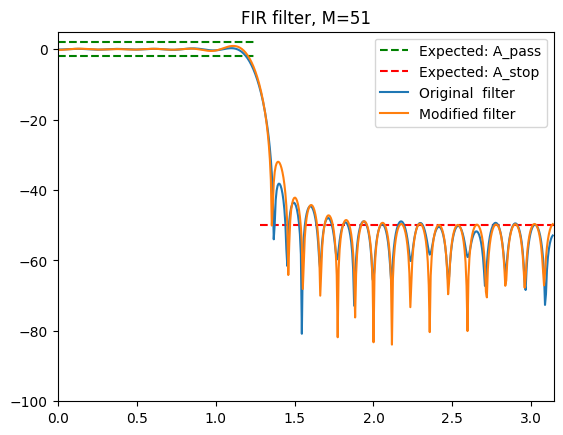

In [94]:
from filter import filter_utils
from filter import rvns_filter

# Parametry zagnieżdżonego algorytmu RVNS
rvnsc_param = {
    'k_prime': 1000,    # Ilość iteracji I stopnia
    'k_bis':   500,     # Ilość iteracji II stopnia
}

# Poprawa filtru algorytmem RVNS
cost_best, coef_best = rvns_filter.rvns_con(coef, filter_n, rvnsc_param['k_prime'], rvnsc_param['k_bis'])

# Wyświetlenie uzyskanych rezultatów
f_b, f_res_b = signal.freqz(coef_best, worN=filter_n['N_fft'])
filter_utils.display_LP_filter(np.append(f[np.newaxis,:],     f_b[np.newaxis,:],     axis=0), 
                               np.append(f_res[np.newaxis,:], f_res_b[np.newaxis,:], axis=0 ), filter_n)

### Uzyskane rezultaty 

In [7]:
cost_val_i = filter_utils.cost_LP_filter(abs(f_res), filter_utils.db_to_linear(filter_n['d1_db'])-1, filter_utils.db_to_linear(filter_n['d2_db']), 
                                        filter_n['f_pass'], filter_n['tr_band'])
cost_val_b = filter_utils.cost_LP_filter(abs(f_res_b), filter_utils.db_to_linear(filter_n['d1_db'])-1, filter_utils.db_to_linear(filter_n['d2_db']), 
                                        filter_n['f_pass'], filter_n['tr_band'])
f_arg   = np.argmin(np.abs(f_res)>filter_utils.db_to_linear(filter_n['d2_db']))
f_b_arg = np.argmin(np.abs(f_res_b)>filter_utils.db_to_linear(filter_n['d2_db']))
f_pass_i = f[f_arg]*filter['fs']/(2*np.pi)
f_pass_b = f_b[f_b_arg]*filter['fs']/(2*np.pi)
print("Wartość funkcji kosztu (metoda okna): {:.4f} ".format(cost_val_i))
print("Wartość funkcji kosztu (metoda sąsiedztwo): {:.4f} ".format(cost_val_b))
print()
print("Pasmo przejściowe (metoda okna): {:.2f} Hz".format(f_pass_i - filter['f_pass']))
print("Pasmo przejściowe (metoda sąsiedztwo): {:.2f} Hz".format(f_pass_b - filter['f_pass']))

NameError: name 'f_res_b' is not defined

In [28]:
import matplotlib.pyplot as plt
def display_LP_filtera(f, f_response, filter_params, labels):
    """_summary_

    Args:
        f (_type_): _description_
        f_response (_type_): _description_
        filter_params (_type_): _description_
    """

    d1 = filter_params["d1_db"]
    d2 = filter_params["d2_db"]
    f_pass = filter_params["f_pass"]
    tr_band = filter_params["tr_band"]
    m_order = filter_params["m_order"]

    # Draw limits
    plt.hlines(-d1, 0, f_pass, linestyles="dashed", colors="g")
    plt.hlines(+d1, 0, f_pass, linestyles="dashed", colors="g")
    plt.hlines(d2, f_pass + tr_band, np.pi, linestyles="dashed", colors="r")

    # Draw filter response
    for i in range(len(f_response)):
        plt.plot(f, 20 * np.log10(abs(f_response[i])), label=labels[i])

    plt.xlim([0, np.pi])
    plt.ylim([-150, 5])
    plt.legend(loc = 'lower left')
    plt.title("FIR filter, M={}".format(m_order))
    plt.show()

## Wykorzystanie algorytmu genetycznego
---

Założenia:
- 14 rodziców

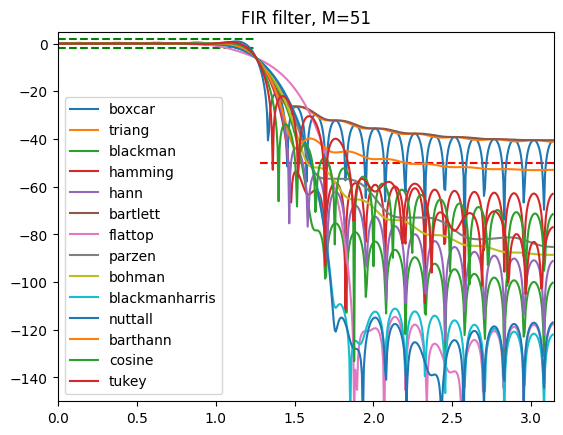

In [34]:
windows = ['boxcar', 'triang', 'blackman', 'hamming', 'hann', 'bartlett', 'flattop', 'parzen', 'bohman', 'blackmanharris', 'nuttall', 'barthann', 'cosine', 'tukey']

f_res_a = []
# Współczynniki filtru metoda okienkowa
for i, w in enumerate(windows):
    coef = signal.firwin(filter['m_order'], filter['f_pass'], fs=filter['fs'], window=w)
    f, f_res = signal.freqz(coef, worN=filter['N_fft'])
    f_res_a.append(f_res)
    
display_LP_filtera(f, f_res_a, filter_n, windows)

### Kroki algorytmu

1. Wygeneruj zbiór początkowy (14 osobników)
2. Dokonaj losowej permutacji zbioru
- Wylicz dla każdego wartość funkcji kosztu

In [12]:
from filter import rvns_filter

N_iter = 500
# Alokacja pamięci  
windows = ['boxcar', 'triang', 'blackman', 'hamming', 'hann', 'bartlett', 'flattop', 'parzen', 
           'bohman', 'blackmanharris', 'nuttall', 'barthann', 'cosine', 'tukey']
M_order = filter['m_order']
K_parents = 14
L_individuals = K_parents + K_parents // 2
solutions = np.zeros((L_individuals, M_order))
cost_value = np.zeros((L_individuals))
prob = 0.8

# Parametry zagnieżdżonego algorytmu RVNS
rvnsc_param = {
    'k_prime': 50,    # Ilość iteracji I stopnia
    'k_bis':   20,     # Ilość iteracji II stopnia
}


# Generate first solution
for i, w in enumerate(windows):
    coef = signal.firwin(filter['m_order'], filter['f_pass'], fs=filter['fs'], window=w)
    solutions[i] = coef
    f, f_res = signal.freqz(coef, worN=filter['N_fft'])
    cost_value[i] = filter_utils.cost_LP_filter(abs(f_res), filter_utils.db_to_linear(filter_n['d1_db'])-1, 
                    filter_utils.db_to_linear(filter_n['d2_db']), filter_n['f_pass'], filter_n['tr_band'])

# Tu pętla
for n_i in range(N_iter):
    # Wylosuj permutacje z 12 najlepszych
    permutation = np.random.permutation(np.arange(K_parents)).reshape((K_parents//2, 2))

    # Mieszanie genów losowo    
    gen_rand = np.random.choice([True, False], (M_order), p=[prob, 1-prob])
    for i in range(K_parents//2):
        solutions[K_parents + i] = gen_rand * solutions[permutation[i, 0]] + np.logical_not(gen_rand) * solutions[permutation[i, 1]]
        # Poprawa filtru algorytmem RVNS
        cost, solutions[K_parents + i] = rvns_filter.rvns_con(solutions[K_parents + i], filter_n, rvnsc_param['k_prime'], rvnsc_param['k_bis'])
        cost_value[K_parents + i] = cost

    # Metoda wyboru rodzica - najlepsi rodzice 
    parents_arg = np.argsort(cost_value)[:K_parents]

    # Modyfikacja rodzica 
    solutions[:K_parents] = solutions[parents_arg]
    cost_value[:K_parents] = cost_value[parents_arg]

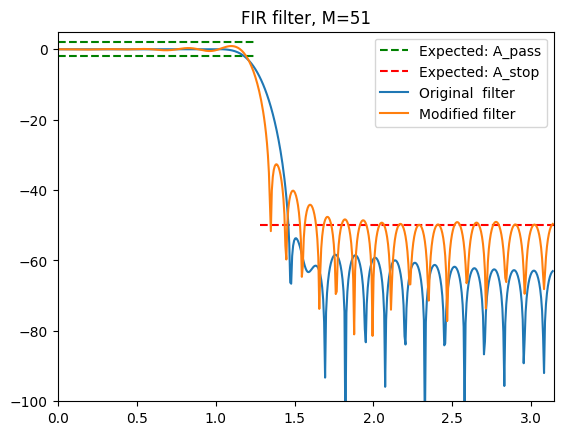

Wartość funkcji kosztu (metoda okna): 38.8707 
Wartość funkcji kosztu (metoda sąsiedztwo): 13.8057 

Pasmo przejściowe (metoda okna): 1603.12 Hz
Pasmo przejściowe (metoda sąsiedztwo): 712.50 Hz


In [13]:
gen_best_solution = solutions[0]
gen_best_val = filter_utils.cost_LP_filter(abs(f_res), filter_utils.db_to_linear(filter_n['d1_db'])-1, 
                                           filter_utils.db_to_linear(filter_n['d2_db']), filter_n['f_pass'], filter_n['tr_band'])

f_gen, f_res_gen = signal.freqz(solutions[0], worN=filter_n['N_fft'])

coef     = signal.firwin(filter['m_order'], filter['f_pass'], fs=filter['fs'], window='hamming')
f, f_res = signal.freqz(coef, worN=filter['N_fft'])

filter_utils.display_LP_filter(np.append(f[np.newaxis,:],     f_gen[np.newaxis,:],     axis=0), 
                               np.append(f_res[np.newaxis,:], f_res_gen[np.newaxis,:], axis=0 ), filter_n)

cost_val_i = filter_utils.cost_LP_filter(abs(f_res), filter_utils.db_to_linear(filter_n['d1_db'])-1, filter_utils.db_to_linear(filter_n['d2_db']), 
                                        filter_n['f_pass'], filter_n['tr_band'])
cost_val_b = filter_utils.cost_LP_filter(abs(f_res_gen), filter_utils.db_to_linear(filter_n['d1_db'])-1, filter_utils.db_to_linear(filter_n['d2_db']), 
                                        filter_n['f_pass'], filter_n['tr_band'])
f_arg   = np.argmin(np.abs(f_res)>filter_utils.db_to_linear(filter_n['d2_db']))
f_b_arg = np.argmin(np.abs(f_res_gen)>filter_utils.db_to_linear(filter_n['d2_db']))
f_pass_i = f[f_arg]*filter['fs']/(2*np.pi)
f_pass_b = f_gen[f_b_arg]*filter['fs']/(2*np.pi)
print("Wartość funkcji kosztu (metoda okna): {:.4f} ".format(cost_val_i))
print("Wartość funkcji kosztu (metoda sąsiedztwo): {:.4f} ".format(cost_val_b))
print()
print("Pasmo przejściowe (metoda okna): {:.2f} Hz".format(f_pass_i - filter['f_pass']))
print("Pasmo przejściowe (metoda sąsiedztwo): {:.2f} Hz".format(f_pass_b - filter['f_pass']))

In [3]:
from filter import hybrid_filter

cost, coe = hybrid_filter.hybrid_gen_rvns(filter_n, 100)

UnboundLocalError: local variable 'filter_n' referenced before assignment

In [6]:
cost

1703.6699779517876